## Integrantes
<ul>
<li>Sebastián Aranda 201104560-2</li>
<li>Felipe Santander 201104528-9</li>
</ul>

# Fronteras de Clasificación

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt

In [ ]:
n_samples=500

#Generating Multivariate Normal Distribution
mean = (0,-4)
C = np.array([[0.3, 0.1], [0.1, 1.5]])
datos1 = np.random.multivariate_normal(mean, C, n_samples)

#Generating Halfmoon Distribution
outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
datos2 = np.vstack((outer_circ_x,outer_circ_y)).T
generator = check_random_state(10)
datos2 += generator.normal(scale=0.3, size=datos2.shape)

Desribir Dataset

In [ ]:
print("Shape Datos1")
print(datos1.shape)
print("Shape Datos2")
print(datos2.shape)

#x,y = datos1.T or x,y = datos1[:,0],datos1[:,1]
x1,y1 = datos1.T
x2,y2 = datos2.T

plt.figure(figsize=(12,6))
plt.plot(x1,y1, 'o')
plt.plot(x2,y2, 'o')
plt.title("Manifold")
plt.show()

Se altera la "etiqueta" de los datos agregando ruido al set de datos.

In [ ]:
X = np.concatenate((datos1, datos2), axis=0)
#y = [i%2 for i in range(len(datos1)+len(datos2))] #No linear separable

n = 100 #Noise
y1 = np.zeros(datos1.shape[0]+n)
y2 = np.ones(datos2.shape[0]-n)
y = np.concatenate((y1,y2),axis=0)

plt.figure(figsize=(12,6))
plt.scatter(X[:,0],X[:,1], c=y)
plt.title("Manifold Changed")
plt.show()

print "X Shape:", X.shape

Analizar cualitativamente LDA y QDA, comparar

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interactive
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import confusion_matrix

def visualize_border(model,x,y,title=""):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

    
def visualize_border_interactive_noise(noise, model_name):
    y1 = np.zeros(datos1.shape[0]+noise)
    y2 = np.ones(datos2.shape[0]-noise)
    y = np.concatenate((y1,y2),axis=0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    if model_name=="LDA":
        model = LDA()
    else:
        model = QDA()
        
    model.fit(X_train,y_train)
    visualize_border(model,X,y,model_name)
    y_pred = model.predict(X_test)
    print("Miss Classification Loss of "+model_name+": %f"%(1-accuracy_score(y_test, y_pred)))
    
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    
interactive(visualize_border_interactive_noise,noise=(0,499),model_name="LDA")

Describir cuantitativamente

### Accuracy:
\begin{equation}
\frac{TP+TN}{TP+TN+FP+FN}
\end{equation}

Analizar comportamiento de los parámetros

In [ ]:
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X,y)

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
def train_model(param):
    model=LR() #define your model
    model.set_params(C=param,penalty='l2')
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 1000 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Analizar valores del parámetro de regularización C para SVM lineal

In [ ]:
from sklearn.svm import SVC as SVM
#SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='linear')
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 10000 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max,0.01))

Analizar valores del parámetro de regularización C para SVM no lineal

In [ ]:
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='rbf')
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 1000 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

In [ ]:
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='poly')
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 1000 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Analizar valores del parámetro de profundidad del árbol de decisión

In [ ]:
from sklearn.tree import DecisionTreeClassifier as Tree
def train_model(param):
    model = Tree()#edit the train_model function
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Analizar valores del parámetro de k del algoritmo de clasificación K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def train_model(param):
    model = KNeighborsClassifier()
    model.set_params(n_neighbors=param)
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 50 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

# Análisis de Audio - Datos Brutos

### <a href="https://www.kaggle.com/kinguistics/heartbeat-sounds">Heartbeat-sounds Kaggle</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.io import wavfile

def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name

SAMPLE_RATE = 44100
def load_wav_file(name, path):
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

In [3]:
df = pd.read_csv('./heartbeat-sounds_dataset/set_a.csv')
df.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [4]:
df['label'].value_counts(dropna=False)

NaN         52
artifact    40
murmur      34
normal      31
extrahls    19
Name: label, dtype: int64

In [5]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux

new_df =pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest')})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='heartbeat-sounds_dataset/set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))
print("DataFrame Edit Ok")

DataFrame Edit Ok


### <a href="https://www.kaggle.com/toregil/new-labels-for-set-a">New labels for set a</a>

Cambiar Labels 

In [6]:
new_labels =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
             1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0,
             2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0,
             0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]

Cambiar clases a valores numéricos para ser trabajados por los clasificadores

In [7]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)

In [8]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape

(176, 396900)

Se procesa la secuencia de tiempo utilizando una <a href="https://en.wikipedia.org/wiki/Fourier_transform">transformada de fourier discreta</a> para pasar los datos desde el dominio de tiempos al de frecuencias, presentes en la señal de sonido

In [9]:
X_fourier = np.abs(np.fft.fft(X))

Muestreo

In [10]:
from scipy import signal

X_resampled = []
for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)

X_resampled = np.array(X_resampled)
X_resampled.shape

(176, 100000)

##### Hold-out Validation

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.25, random_state=42)

#Standarization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

print "X_train.shape: ", X_train.shape
print "y_train.shape: ", y_train.shape

X_train.shape:  (132, 100000)
y_train.shape:  (132,)


PCA X_train.shape:  (132, 2)


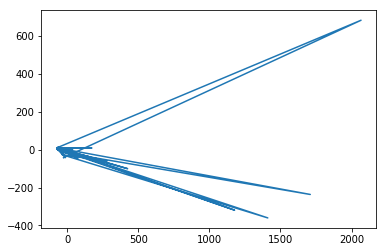

In [13]:
#PCA
from sklearn.decomposition import PCA
d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

print "PCA X_train.shape: ", X_pca_train.shape
plt.figure(figsize=(12,6))
plt.plot(X_pca_train[:,0], X_pca_train[:,1])
plt.show()

Construir gráfico de error de entrenamiento y testeo en función del hiper-parámetro de regularización C para un modelo de Regresión Logística y para otro de SVM con kernel lineal

Logistic Regression Error's Plot


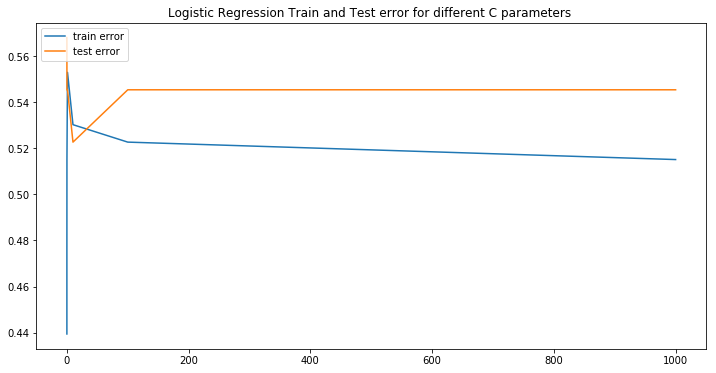

SVM Error's Plot


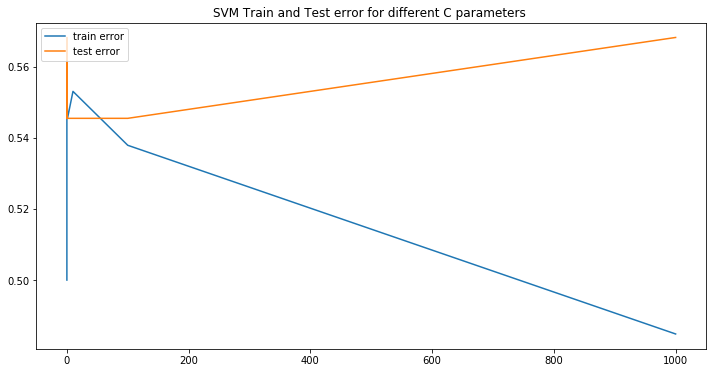

Decision Tree Error's Plot


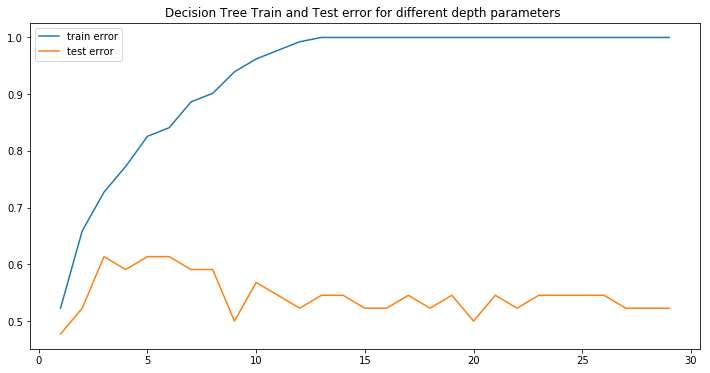

In [17]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM
from sklearn.model_selection import train_test_split

Cs = [0.0001,0.01,0.1,1,10,100,1000]

e_train = []
e_test = []
for c in Cs:
    model = LR()
    model.set_params(C=c,penalty='l2')
    model.fit(X_pca_train,y_train)
    e_train.append(model.score(X_pca_train,y_train))
    e_test.append(model.score(X_pca_test,y_test))
    
print("Logistic Regression Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Logistic Regression Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

e_train = []
e_test = []
for c in Cs:    
    model = SVM()
    model.set_params(C=c,kernel='linear')
    model.fit(X_pca_train,y_train)
    e_train.append(model.score(X_pca_train,y_train))
    e_test.append(model.score(X_pca_test,y_test))
    
print("SVM Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("SVM Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

from sklearn.tree import DecisionTreeClassifier as Tree

Depths = range(1,30)
e_train = []
e_test = []
for d in Depths:
    model = Tree()
    model.set_params(max_depth=d,criterion='gini',splitter='best')
    model.fit(X_pca_train,y_train)
    e_train.append(model.score(X_pca_train,y_train))
    e_test.append(model.score(X_pca_test,y_test))

print("Decision Tree Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Decision Tree Train and Test error for different depth parameters ")
plt.plot(Depths,e_train, label="train error")
plt.plot(Depths,e_test, label="test error")
plt.legend(loc=2)
plt.show()

Experimente con diferentes dimensiones <i>d</i> para la proyección de PCA con el propósito de obtener un modelo con menor error. Construya una tabla o grafico resumen

Realice otra reducción de dimensionalidad ahora a través de la técnica LDA, para representar los datos en <i>d</i> = 2 dimensiones. Recuerde que solo se debe ajustar con el conjunto de entrenamiento, si se muestra un warning explique el por qué. Visualice apropiadamente la proyección en 2 dimensiones.

/home/sebastian/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA X_train.shape:  (132, 2)


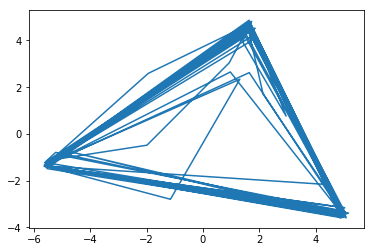

In [18]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_lda = LDA(n_components=2)
model_lda.fit(X_train,y_train)
X_lda_train = model_lda.transform(X_train)
X_lda_test = model_lda.transform(X_test)

print "LDA X_train.shape: ", X_lda_train.shape
plt.figure()
plt.plot(X_lda_train[:,0], X_lda_train[:,1])
plt.show()

Logistic Regression Error's Plot


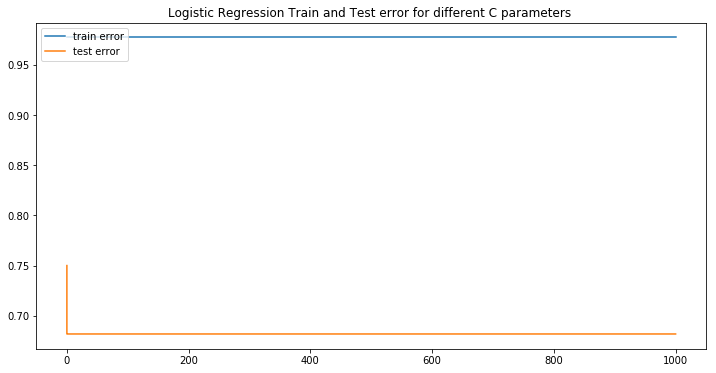

SVM Error's Plot


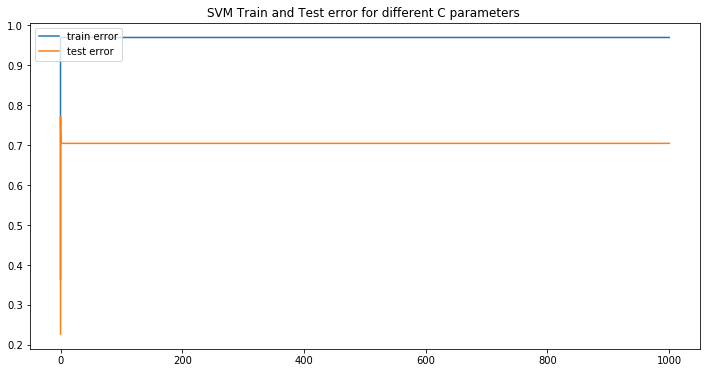

Decision Tree Error's Plot


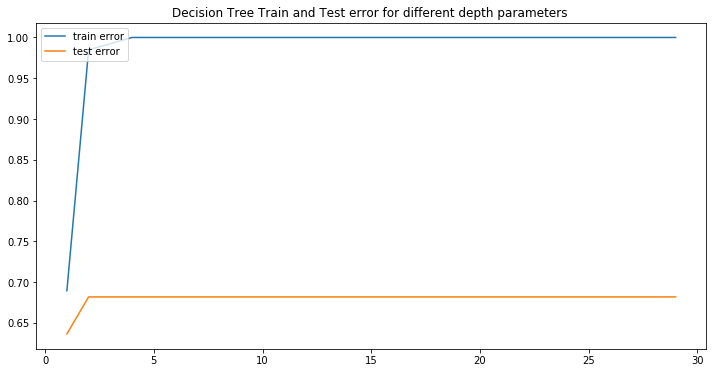

In [20]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM
from sklearn.model_selection import train_test_split

Cs = [0.0001,0.01,0.1,1,10,100,1000]

e_train = []
e_test = []
for c in Cs:
    model = LR()
    model.set_params(C=c,penalty='l2')
    model.fit(X_lda_train,y_train)
    e_train.append(model.score(X_lda_train,y_train))
    e_test.append(model.score(X_lda_test,y_test))
    
print("Logistic Regression Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Logistic Regression Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

e_train = []
e_test = []
for c in Cs:    
    model = SVM()
    model.set_params(C=c,kernel='linear')
    model.fit(X_lda_train,y_train)
    e_train.append(model.score(X_lda_train,y_train))
    e_test.append(model.score(X_lda_test,y_test))
    
print("SVM Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("SVM Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

from sklearn.tree import DecisionTreeClassifier as Tree

Depths = range(1,30)
e_train = []
e_test = []
for d in Depths:
    model = Tree()
    model.set_params(max_depth=d,criterion='gini',splitter='best')
    model.fit(X_lda_train,y_train)
    e_train.append(model.score(X_lda_train,y_train))
    e_test.append(model.score(X_lda_test,y_test))

print("Decision Tree Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Decision Tree Train and Test error for different depth parameters ")
plt.plot(Depths,e_train, label="train error")
plt.plot(Depths,e_test, label="test error")
plt.legend(loc=2)
plt.show()

Con el propósito de encontrar el mejor modelo vuelva a realizar el item h) con el i) en el nuevo espacio generado por la representación según las <i>d</i> dimensiones de la proyección LDA. Esta nueva representación ¿mejora o empeora el desempeño? Explique

##### Feature Crafting

### <a href="https://www.kaggle.com/primaryobjects/voicegender">Voice Classification</a>

# Análisis de Emociones - Twitter

<a href="https://www.crowdflower.com/data-for-everyone/">Crowd Flower</a>

In [123]:
import pandas as pd
file_path = './text_emotion.csv'
df = pd.read_csv(file_path)
descripcion = df.apply(lambda x: len(x.unique()))
sentimientos = df.sentiment.unique()
print sentimientos
print descripcion

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']
tweet_id     40000
sentiment       13
author       33871
content      39827
dtype: int64


In [124]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import HTMLParser
df["content_pre"] = ""
stop = stopwords.words('english')
puncts = ".,:;?!()[]{}~+-\"\'#$%&"
tt = TweetTokenizer(strip_handles=True)
ps = PorterStemmer()
wd = WordNetLemmatizer()
html_parser = HTMLParser.HTMLParser()
df["sentiment_bi"] = 0
negativos = ['surprise', 'empty', 'sadness', 'worry', 'hate', 'boredom', 'anger']
positivos = ['neutral', 'enthusiasm', 'love', 'fun', 'happiness', 'relief']
df["sentiment_cod"] = 0
sentimientos_cod = {key: value for (value, key) in enumerate(sentimientos)}
for row, col in df.iterrows():
    content = df.loc[row, "content"]
    
    #Eliminando links, parseando tags html, pasando a minusculas y eliminando numeros
    #content = html_parser.unescape(content)
    content = re.sub(r"http\S+", "", content)
    content = content.lower().replace('\d+', '')
    
    #Eliminando signos y puntuaciones
    for sym in puncts:
        content = content.replace(sym, ' ')
        
    #Eliminando Stopwords
    content = ' '.join([word for word in content.split() if word not in stop])
    
    #Tokenizando
    content = tt.tokenize(content)
    
    #Stemming
    content = [ps.stem(word) for word in content]
    
    #Lemmatisation
    content = [wd.lemmatize(word) for word in content]
    content = ' '.join([word for word in content])
    
    #Guardar en columna "content_pre"
    df.set_value(row, "content_pre", content)
    
    sentimiento = df.loc[row, "sentiment"]
    if sentimiento in negativos:
        df.loc[row, "sentiment_bi"] = -1
    else:
        df.loc[row, "sentiment_bi"] = 1
    
    #i
    df.loc[row, "sentiment_cod"] = sentimientos_cod.get(sentimiento)
    
df["sentiment_bi"].astype(int)

C:\Users\Paralizis\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:32: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


0       -1
1       -1
2       -1
3        1
4        1
5       -1
6       -1
7       -1
8       -1
9       -1
10       1
11      -1
12      -1
13      -1
14      -1
15      -1
16       1
17      -1
18      -1
19      -1
20      -1
21       1
22       1
23      -1
24      -1
25      -1
26      -1
27      -1
28      -1
29      -1
        ..
39970    1
39971    1
39972    1
39973    1
39974    1
39975   -1
39976    1
39977   -1
39978   -1
39979   -1
39980    1
39981    1
39982    1
39983    1
39984   -1
39985    1
39986    1
39987    1
39988    1
39989    1
39990    1
39991    1
39992    1
39993    1
39994    1
39995    1
39996    1
39997    1
39998    1
39999    1
Name: sentiment_bi, dtype: int32

In [125]:
print df.iloc[:30,4:-1]

                                          content_pre  sentiment_bi
0   know listenin bad habit earlier start freakin ...            -1
1              layin n bed headach ughhhh waitin call            -1
2                        funer ceremoni gloomi friday            -1
3                               want hang friend soon             1
4                want trade someon houston ticket one             1
5                      ping go prom bc bf like friend            -1
6   sleep im think old friend want marri damn amp ...            -1
7                                                hmmm            -1
8                                   charlen love miss            -1
9                                  sorri least friday            -1
10                                   cant fall asleep             1
11                                       choke retain            -1
12                 ugh beat stupid song get next rude            -1
13  u watch hill london u realis tourtur week we

In [126]:
import numpy as np
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]

In [127]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
# feature extraction
#TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True,use_idf = True,ngram_range=(1, 2)) #TfidfVectorizer(min_df = 3)  
train_X_tfidf = vectorizer.fit_transform(df_train.content_pre)
test_X = vectorizer.transform(df_test.content_pre)
train_y = df_train.sentiment_bi
test_y = df_test.sentiment_bi

# #############################################################################
#Clasificadores
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

#Multinomial Naive Bayes
clf_mnb = MultinomialNB().fit(train_X_tfidf, train_y)
clf_score_train = clf_mnb.score(train_X_tfidf, train_y)
clf_score_test = clf_mnb.score(test_X, test_y)
print 'Multinomial Naive Bayes score: Train: {} Test: {}'.format(clf_score_train, clf_score_test)

#Regresion logística
clf_logreg = LogisticRegression().fit(train_X_tfidf, train_y)
clf_score_train = clf_logreg.score(train_X_tfidf, train_y)
clf_score_test = clf_logreg.score(test_X, test_y)
print 'Regresion logística score: Train: {} Test: {}'.format(clf_score_train, clf_score_test)

#SVM
clf_svc = SVC().fit(train_X_tfidf, train_y)
clf_score_train = clf_svc.score(train_X_tfidf, train_y)
clf_score_test = clf_svc.score(test_X, test_y)
print 'SVC score: Train: {} Test: {}'.format(clf_score_train, clf_score_test)

#Linear SVM
clf_lsvc = LinearSVC().fit(train_X_tfidf, train_y)
clf_score_train = clf_lsvc.score(train_X_tfidf, train_y)
clf_score_test = clf_lsvc.score(test_X, test_y)
print 'Linear SVC score: Train: {} Test: {}'.format(clf_score_train, clf_score_test)

#Arboles de decisión
clf_ad = DecisionTreeClassifier().fit(train_X_tfidf, train_y)
clf_score_train = clf_ad.score(train_X_tfidf, train_y)
clf_score_test = clf_ad.score(test_X, test_y)
print 'Arboles de decisión score: Train: {} Test: {}'.format(clf_score_train, clf_score_test)

Multinomial Naive Bayes score: Train: 0.75971366947 Test: 0.688225746036
Regresion logística score: Train: 0.768434872308 Test: 0.698089649145
SVC score: Train: 0.544121784252 Test: 0.542264951929
Linear SVC score: Train: 0.79534869182 Test: 0.680109876389
Arboles de decisión score: Train: 0.983151511363 Test: 0.639655387689


In [128]:
from sklearn.metrics import accuracy_score
def data_size_response(model,trX,teX,trY,teY,n_subsets=20):
    train_errs,test_errs = [],[]
    subset_sizes = np.exp(np.linspace(3,np.log(trX.shape[0]),n_subsets)).astype(int)
    for m in subset_sizes:
        model.fit(trX[:m],trY[:m])
        train_err = model.score(trX[:m], trY[:m])
        test_err = model.score(teX, teY)
        #print "training error: %.3f test error: %.3f subset size: %.3f" % (train_err,test_err,m)
        train_errs.append(train_err)
        test_errs.append(test_err)
    return subset_sizes,train_errs,test_errs

def plot_response(subset_sizes,train_errs,test_errs):
    plt.plot(subset_sizes,train_errs,lw=2)
    plt.plot(subset_sizes,test_errs,lw=2)
    plt.legend(['Score de entrenamiento','Score de test'])
    plt.xscale('log')
    plt.xlabel('Tamanio dataset')
    plt.ylabel('Score')
    plt.title('Score de entrenamiento vs Score de test')
    plt.show()


Clasificador: Multinomial Naive Bayes


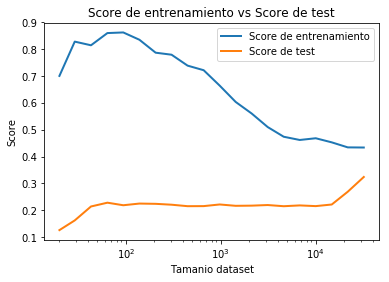

---------------------------------------------------
Clasificador: Logistic Regression


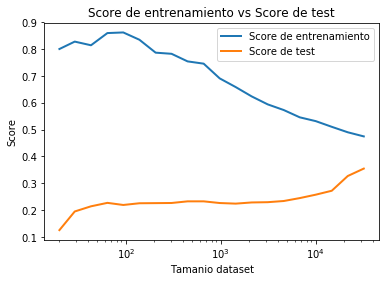

---------------------------------------------------
Clasificador: SVM


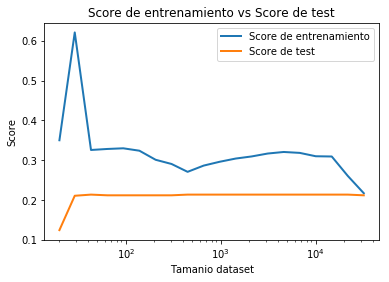

---------------------------------------------------
Clasificador: Linear SVM


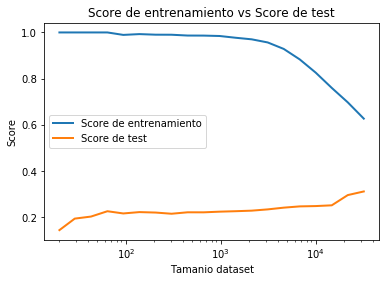

---------------------------------------------------
Clasificador: Arbol de decision


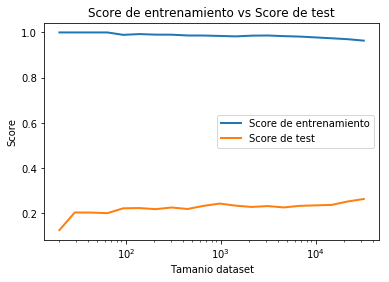

---------------------------------------------------


In [129]:
# Igual que en c) y e) 
vectorizer = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True,use_idf = True,ngram_range=(1, 2)) #TfidfVectorizer(min_df = 3)  
train_X = vectorizer.fit_transform(df_train.content_pre)
test_X = vectorizer.transform(df_test.content_pre)
train_y = df_train.sentiment_cod
test_y = df_test.sentiment_cod

import matplotlib.pyplot as plt
clf_list = [(MultinomialNB(),"Multinomial Naive Bayes"),
            (LogisticRegression(), "Logistic Regression"),
            (SVC(),"SVM"), 
            (LinearSVC(),"Linear SVM"), 
            (DecisionTreeClassifier(),"Arbol de decision")]
for clf, clf_name in clf_list:
    print "Clasificador: {}".format(clf_name)
    response = data_size_response(clf,train_X,test_X,train_y,test_y)
    plot_response(*response)
    print "---------------------------------------------------"


In [130]:
from sklearn.metrics import classification_report
def score_the_model(model,x,y,xt,yt):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "Training Accuracy: %f"%(acc_tr)
    print "Test Accuracy: %f"%(acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=["+1","-1"]))
clf_list_fitted = [(clf_mnb,"Multinomial Naive Bayes"), 
                   (clf_logreg, "Logistic Regression"),
                   (clf_svc,"SVM"),
                   (clf_lsvc,"Linear SVM"),
                   (clf_ad,"Arbol de decision")]
for clf, clf_name in clf_list_fitted:
    print "Clasificador: {}".format(clf_name)
    score_the_model(clf, train_X_tfidf, df_train.sentiment_bi, test_X, df_test.sentiment_bi)
    print "---------------------------------------------------"

Clasificador: Multinomial Naive Bayes
Training Accuracy: 0.759714
Test Accuracy: 0.688187
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         +1       0.68      0.60      0.64      3666
         -1       0.69      0.76      0.73      4343

avg / total       0.69      0.69      0.69      8009

---------------------------------------------------
Clasificador: Logistic Regression
Training Accuracy: 0.768435
Test Accuracy: 0.698052
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         +1       0.69      0.61      0.65      3666
         -1       0.70      0.77      0.73      4343

avg / total       0.70      0.70      0.70      8009

---------------------------------------------------
Clasificador: SVM
Training Accuracy: 0.544122
Test Accuracy: 0.542208
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         +1       0.00      0.00      0.00      3666

In [131]:
from sklearn import metrics
for clf, clf_name in clf_list_fitted:
    print "Clasificador: {}".format(clf_name)
    print(metrics.confusion_matrix(df_test.sentiment_bi, clf.predict(test_X)))
    print "---------------------------------------------------"
# tn fo
# fn tp
# fo error tipo 1
# fn error tipo 2

Clasificador: Multinomial Naive Bayes
[[2207 1459]
 [1038 3305]]
---------------------------------------------------
Clasificador: Logistic Regression
[[2238 1428]
 [ 990 3353]]
---------------------------------------------------
Clasificador: SVM
[[   0 3666]
 [   0 4343]]
---------------------------------------------------
Clasificador: Linear SVM
[[2218 1448]
 [1114 3229]]
---------------------------------------------------
Clasificador: Arbol de decision
[[2188 1478]
 [1408 2935]]
---------------------------------------------------


In [132]:
def clf_multi(model, x_train, y_train, x_test, y_test):
    #vec_clf = Pipeline([('vectorizer', vec), ('pac', model)])
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print "Training Accuracy: %f"%(model.score(x_train, y_train))
    print "Test Accuracy: %f"%(model.score(x_test, y_test))
    print sklearn.metrics.classification_report(y_test, y_pred)

In [133]:
import sklearn.metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier

clf_list = [(MultinomialNB(), "Multinomial Naive Bayes"),
            (BernoulliNB(alpha=.01), "Bernoull Naive Bayes"),
            (NearestCentroid(), "NearestCentroid"),
            (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
            (DecisionTreeClassifier(), "Arbol de decision")]
for clf, clf_name in clf_list:
    print "Clasificador: {}".format(clf_name)
    clf_multi(clf, train_X, train_y, test_X, test_y)
    print "---------------------------------------------------"

Clasificador: Multinomial Naive Bayes
Training Accuracy: 0.433716
Test Accuracy: 0.324135
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       176
          1       0.34      0.12      0.18       996
          2       0.00      0.00      0.00       159
          3       0.30      0.60      0.40      1696
          4       0.31      0.56      0.40      1710
          5       0.00      0.00      0.00       439
          6       0.56      0.28      0.38       800
          7       0.00      0.00      0.00       360
          8       0.00      0.00      0.00       283
          9       0.36      0.25      0.30      1022
         10       0.00      0.00      0.00        36
         11       0.00      0.00      0.00       306
         12       0.00      0.00      0.00        26

avg / total       0.27      0.32      0.27      8009

---------------------------------------------------
Clasificador: Bernoull Naive Bayes
Training Accuracy: 0.5665

Clasificador: Multinomial Naive Bayes


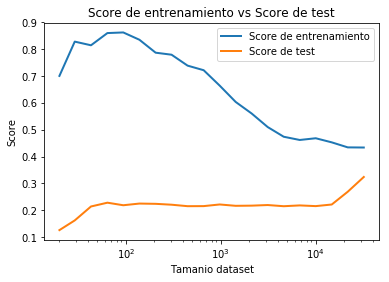

Clasificador: Bernoull Naive Bayes


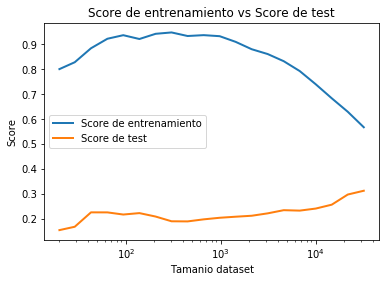

Clasificador: NearestCentroid


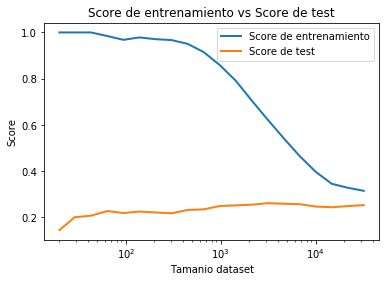

Clasificador: Ridge Classifier


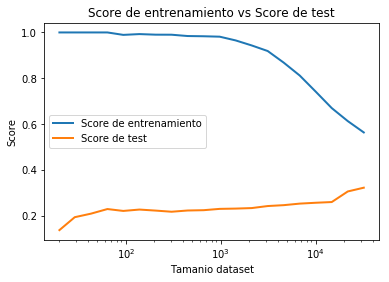

Clasificador: Arbol de decision


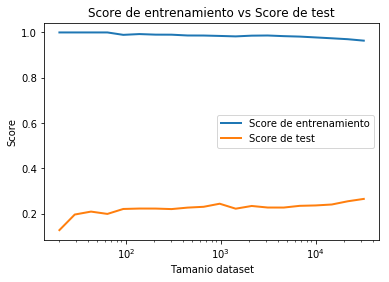

In [134]:
for clf, clf_name in clf_list:
    print "Clasificador: {}".format(clf_name)
    response = data_size_response(clf,train_X,test_X,train_y,test_y)
    plot_response(*response)

In [135]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import SGDClassifier
clf_list = [(SGDClassifier(),"SGDClassifier"),
            (LogisticRegression(), "Logistic Regression"), 
            (LinearSVC(),"Linear SVM")]
for clf, clf_name in clf_list:
    clf_oo = OneVsOneClassifier(clf).fit(train_X, train_y)
    clf_score_train = clf_oo.score(train_X, train_y)
    clf_score_test = clf_oo.score(test_X, test_y)
    print '{} score: Train: {} Test: {}'.format(clf_name, clf_score_train, clf_score_test)

SGDClassifier score: Train: 0.504298083836 Test: 0.349356973405
Logistic Regression score: Train: 0.454315276171 Test: 0.349356973405
Linear SVM score: Train: 0.652714826045 Test: 0.325009364465


In [136]:
from sklearn.multiclass import OneVsRestClassifier
for clf, clf_name in clf_list:
    clf_or = OneVsRestClassifier(clf).fit(train_X, train_y)
    clf_score_train = clf_or.score(train_X, train_y)
    clf_score_test = clf_or.score(test_X, test_y)
    print '{} score: Train: {} Test: {}'.format(clf_name, clf_score_train, clf_score_test)

SGDClassifier score: Train: 0.549435778813 Test: 0.302409788987
Logistic Regression score: Train: 0.474539714295 Test: 0.354725933325
Linear SVM score: Train: 0.627051358194 Test: 0.311399675365


In [137]:
lr_list = ((OneVsRestClassifier(LogisticRegression(multi_class="ovr")), "LR extendida OvsR"),
           (LogisticRegression(multi_class="multinomial", solver="newton-cg"), "LR extendida multinomial"))
for lr, lr_name in lr_list:
    clf = lr.fit(train_X, train_y)
    clf_score_train = clf.score(train_X, train_y)
    clf_score_test = clf.score(test_X, test_y)
    print '{} score: Train: {} Test: {}'.format(lr_name, clf_score_train, clf_score_test)

LR extendida OvsR score: Train: 0.474539714295 Test: 0.354725933325
LR extendida multinomial score: Train: 0.490356662811 Test: 0.351854164065


In [138]:
clf_list_multi = [(MultinomialNB(), "Multinomial Naive Bayes"),
                  (BernoulliNB(alpha=.01), "Bernoull Naive Bayes"),
                  (NearestCentroid(), "NearestCentroid"),
                  (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
                  (DecisionTreeClassifier(), "Arbol de decision")]

clf_list_ext = [(SGDClassifier(),"SGDClassifier"),
                (LogisticRegression(), "Logistic Regression"),
                (LinearSVC(),"Linear SVM")]

print "Multiclase: "
for clf, clf_name in clf_list_multi:
    clf = clf.fit(train_X, train_y)
    clf_score_train = clf.score(train_X, train_y)
    clf_score_test = clf.score(test_X, test_y)
    print '{} score: Train: {} Test: {}'.format(clf_name, clf_score_train, clf_score_test)
    
print "---------------------------------------------------" 

print "Extendidos por One vs One: "
for clf, clf_name in clf_list_ext:
    clf_oo = OneVsOneClassifier(clf).fit(train_X, train_y)
    clf_score_train = clf_oo.score(train_X, train_y)
    clf_score_test = clf_oo.score(test_X, test_y)
    print '{} score: Train: {} Test: {}'.format(clf_name, clf_score_train, clf_score_test)

Multiclase: 
Multinomial Naive Bayes score: Train: 0.43371573255 Test: 0.324135347734
Bernoull Naive Bayes score: Train: 0.566534337783 Test: 0.311774253964
NearestCentroid score: Train: 0.314994842299 Test: 0.253090273442
Ridge Classifier score: Train: 0.563002094339 Test: 0.322262454738
Arbol de decision score: Train: 0.963771060611 Test: 0.265326507679
---------------------------------------------------
Extendidos por One vs One: 
SGDClassifier score: Train: 0.504673189335 Test: 0.350230990136
Logistic Regression score: Train: 0.454315276171 Test: 0.349356973405
Linear SVM score: Train: 0.652714826045 Test: 0.325009364465
